In [2]:
import pandas as pd
import numpy as np
from pylab import mpl, plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Data Preparation for Model Training

### Data Reading

In [4]:
start_date = '2016-01-01'
finish_date = '2021-03-01'

price = pd.read_csv("../data generators/generated_price_data/btc-usd_daily.csv")
price = price[['market','day','close']]
price.index = price['day']
price = price[(price['day'] >= start_date) & (price['day'] <= finish_date)]

g_trends = pd.read_csv("../data generators/generated_trends_data/bitcoin_daily.csv")
g_trends = g_trends[['keyword','day','trend']]
g_trends.index = g_trends['day']
g_trends = g_trends[(g_trends['day'] >= start_date) & (g_trends['day'] <= finish_date)]

g_trends2 = pd.read_csv("../data generators/generated_trends_data/coinbase_daily.csv")
g_trends2 = g_trends2[['keyword','day','trend']]
g_trends2.index = g_trends2['day']
g_trends2 = g_trends2[(g_trends2['day'] >= start_date) & (g_trends2['day'] <= finish_date)]

w_pageview = pd.read_csv("../data generators/generated_wiki_pageview_data/Bitcoin_daily.csv")
w_pageview = w_pageview[['article','day','pageview']]
w_pageview.index = w_pageview['day']
w_pageview = w_pageview[(w_pageview['day'] >= start_date) & (w_pageview['day'] <= finish_date)]

In [5]:
### Feature Extraction
def create_features(data,key_val,window_len):
    features = np.zeros((1,window_len))
    for t in range(data.shape[0]-window_len):
        d = data[key_val].values[t:t+window_len].reshape(1,window_len)
        
        #Normalization to z-scores
        d = (d-d.mean())/np.std(d)
        features = np.concatenate((features,d))
    return features[1:,:]

In [6]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import RandomizedSearchCV

random_grids = {'gb' : {'n_estimators': [25,50,100,200],
                        'learning_rate': [0.01,0.05,0.1,0.2],
                        'max_depth': [3,5,10,20]},
                'rf' : {'n_estimators': [25,50,100,150,200],
                       'max_features': ['auto','sqrt'],
                       'max_depth': [3,5,10,20],
                       'min_samples_split': [5,10,20],
                       'min_samples_leaf': [1,5,10],
                       'bootstrap': [True,False]},
                'ab' : {'n_estimators': [25,50,100,200],
                        'learning_rate': [0.01,0.05,0.1,0.2]},
                'bg' : {'n_estimators': [25,50,100,200],
                        'bootstrap': [True,False]}
                }

In [7]:
models = dict()
preds = dict()

window_len_list = [14,30]

In [8]:

for window_len in window_len_list:    
    ### Create Features
    price_features = create_features(price,'close',window_len)
    g_trends_features = create_features(g_trends,'trend',window_len)
    g_trends2_features = create_features(g_trends2,'trend',window_len)
    w_pageview_features = create_features(w_pageview,'pageview',window_len)

    features = np.hstack((price_features,g_trends_features,g_trends_features,w_pageview_features))
    
    ### Assigning Class Labels

    returns = (price['close'] / price['close'].shift(1))-1
    returns = returns[window_len:]
    classes = np.array([ 1 if r >= 0 else -1 for r in returns ])
    classes = classes.reshape(classes.shape[0],1)

    ### Model Training & Hyperparameter Tuning

    train_len = features.shape[0]-price[price['day'] >= '2019-12-31'].shape[0]
    x_train = features[:train_len,:]
    y_train = classes[:train_len,:]

    x_test = features[train_len:,:]
    y_test = classes[train_len:,:]

    ### Gradient Boosting Classifier
    print('Gradient Boosting Classifier','window_len',window_len)
    gb = GradientBoostingClassifier()
    gb_random = RandomizedSearchCV(estimator = gb, 
                                   param_distributions = random_grids['gb'], 
                                   n_iter = 50, 
                                   cv = 4, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs = -1)
    gb_random.fit(x_train, y_train)
    models['gb_w'+str(window_len)] = gb_random.best_estimator_
    preds['gb_w'+str(window_len)] = models['gb_w'+str(window_len)].predict(x_test)[1:]
    
    print('\ttraining score:',gb_random.best_estimator_.score(x_train, y_train))
    print('\ttest score:',gb_random.best_estimator_.score(x_test,y_test))
    
    ### Random Forest Classifier
    print('RandomForestClassifier','window_len',window_len)
    rf = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = rf, 
                                   param_distributions = random_grids['rf'], 
                                   n_iter = 50, 
                                   cv = 4, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs = -1)
    rf_random.fit(x_train, y_train)    
    models['rf_w'+str(window_len)] = rf_random.best_estimator_
    preds['rf_w'+str(window_len)] = models['rf_w'+str(window_len)].predict(x_test)[1:]
    
    print('\ttraining score:',rf_random.best_estimator_.score(x_train, y_train))
    print('\ttest score:',rf_random.best_estimator_.score(x_test,y_test))
    
    ### AdaBoost Classifier
    print('AdaBoostClassifier','window_len',window_len)
    ab = AdaBoostClassifier()
    ab_random = RandomizedSearchCV(estimator = ab, 
                                   param_distributions = random_grids['ab'], 
                                   n_iter = 50, 
                                   cv = 4, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs = -1)
    ab_random.fit(x_train, y_train)    
    models['ab_w'+str(window_len)] = ab_random.best_estimator_
    preds['ab_w'+str(window_len)] = models['ab_w'+str(window_len)].predict(x_test)[1:]
    
    print('\ttraining score:',ab_random.best_estimator_.score(x_train, y_train))
    print('\ttest score:',ab_random.best_estimator_.score(x_test,y_test))
    
    ### Bagging Classifier
    print('BaggingClassifier','window_len',window_len)
    bg = BaggingClassifier()
    bg_random = RandomizedSearchCV(estimator = bg, 
                                   param_distributions = random_grids['bg'], 
                                   n_iter = 50, 
                                   cv = 4, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs = -1)
    bg_random.fit(x_train, y_train)    
    models['bg_w'+str(window_len)] = bg_random.best_estimator_
    preds['bg_w'+str(window_len)] = models['bg_w'+str(window_len)].predict(x_test)[1:]
    
    print('\ttraining score:',bg_random.best_estimator_.score(x_train, y_train))
    print('\ttest score:',bg_random.best_estimator_.score(x_test,y_test))
    """
    ### Gaussian Naive Bayes Classifier
    print('GaussianNB','window_len',window_len)
    gnb = GaussianNB()
    gnb_random = RandomizedSearchCV(estimator = gnb, 
                                    n_iter = 50, 
                                    cv = 4, 
                                    verbose=2, 
                                    random_state=42, 
                                    n_jobs = -1)
    gnb_random.fit(x_train, y_train)    
    models['gnb_w'+str(window_len)] = gnb_random.best_estimator_
    preds['gnb_w'+str(window_len)] = models['gnb_w'+str(window_len)].predict(x_test)[1:]
    
    print('\ttraining score:',gnb_random.best_estimator_.score(x_train, y_train))
    print('\ttest score:',gnb_random.best_estimator_.score(x_test,y_test))
    """
    

Gradient Boosting Classifier window_len 14
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.1min finished


	training score: 0.5622406639004149
	test score: 0.5644028103044496
RandomForestClassifier window_len 14
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   16.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


	training score: 0.5940525587828492
	test score: 0.5573770491803278
AdaBoostClassifier window_len 14
Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:    9.3s finished


	training score: 0.5629322268326418
	test score: 0.5573770491803278
BaggingClassifier window_len 14
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   28.5s finished


	training score: 1.0
	test score: 0.550351288056206
Gradient Boosting Classifier window_len 30
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.4min finished


	training score: 0.6293706293706294
	test score: 0.5690866510538641
RandomForestClassifier window_len 30
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   22.7s finished


	training score: 0.644055944055944
	test score: 0.5597189695550351
AdaBoostClassifier window_len 30
Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:   19.5s finished


	training score: 0.6006993006993007
	test score: 0.5550351288056206
BaggingClassifier window_len 30
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  1.1min finished


	training score: 0.9993006993006993
	test score: 0.5480093676814989


In [20]:
for window_len in window_len_list:    
    ### Bagging Classifier
    print('BaggingClassifier','window_len',window_len)
    bg = BaggingClassifier()
    bg_random = RandomizedSearchCV(estimator = bg, 
                                   param_distributions = random_grids['bg'], 
                                   n_iter = 50, 
                                   cv = 4, 
                                   verbose=2, 
                                   random_state=42, 
                                   n_jobs = -1)
    bg_random.fit(x_train, y_train)    
    models['bg_w'+str(window_len)] = bg_random.best_estimator_
    preds['bg_w'+str(window_len)] = models['bg_w'+str(window_len)].predict(x_test)[1:]
    
    print('\ttraining score:',bg_random.best_estimator_.score(x_train, y_train))
    print('\ttest score:',bg_random.best_estimator_.score(x_test,y_test))

BaggingClassifier window_len 14
Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
exception calling callback for <Future at 0x7fc70c5d4850 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 347, in __call__
    self.parallel.dispatch_next()
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 780, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 847, in dispatch_one_batch
    self._dispatch(tasks)
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/parallel.py", line 765, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/opt/anaconda3/lib/python3.8/site-packages/joblib/_parallel_backends.py", li

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6), SIGABRT(-6)}

In [9]:
for window_len in window_len_list:    
    ### Create Features
    price_features = create_features(price,'close',window_len)
    g_trends_features = create_features(g_trends,'trend',window_len)
    g_trends2_features = create_features(g_trends2,'trend',window_len)
    w_pageview_features = create_features(w_pageview,'pageview',window_len)

    features = np.hstack((price_features,g_trends_features,g_trends_features,w_pageview_features))
    
    ### Assigning Class Labels

    returns = (price['close'] / price['close'].shift(1))-1
    returns = returns[window_len:]
    classes = np.array([ 1 if r >= 0 else -1 for r in returns ])
    classes = classes.reshape(classes.shape[0],1)

    ### Model Training & Hyperparameter Tuning

    train_len = features.shape[0]-price[price['day'] >= '2019-12-31'].shape[0]
    x_train = features[:train_len,:]
    y_train = classes[:train_len,:]

    x_test = features[train_len:,:]
    y_test = classes[train_len:,:]
    
    ### Gaussian Naive Bayes Classifier
    print('GaussianNB','window_len',window_len)
    gnb = GaussianNB()
    gnb.fit(x_train, y_train)    
    models['gnb_w'+str(window_len)] = gnb
    preds['gnb_w'+str(window_len)] = models['gnb_w'+str(window_len)].predict(x_test)[1:]
    
    print('\ttraining score:',gnb.score(x_train, y_train))
    print('\ttest score:',gnb.score(x_test,y_test))

GaussianNB window_len 14
	training score: 0.5573997233748271
	test score: 0.49414519906323184
GaussianNB window_len 30
	training score: 0.5713286713286714
	test score: 0.5269320843091335


In [10]:
from sklearn.svm import SVC
for window_len in window_len_list:    
    ### Create Features
    price_features = create_features(price,'close',window_len)
    g_trends_features = create_features(g_trends,'trend',window_len)
    g_trends2_features = create_features(g_trends2,'trend',window_len)
    w_pageview_features = create_features(w_pageview,'pageview',window_len)

    features = np.hstack((price_features,g_trends_features,g_trends_features,w_pageview_features))
    
    ### Assigning Class Labels

    returns = (price['close'] / price['close'].shift(1))-1
    returns = returns[window_len:]
    classes = np.array([ 1 if r >= 0 else -1 for r in returns ])
    classes = classes.reshape(classes.shape[0],1)

    ### Model Training & Hyperparameter Tuning

    train_len = features.shape[0]-price[price['day'] >= '2019-12-31'].shape[0]
    x_train = features[:train_len,:]
    y_train = classes[:train_len,:]

    x_test = features[train_len:,:]
    y_test = classes[train_len:,:]
    
    ### SVM Classifier
    print('SVMClassifier','window_len',window_len)
    svm = SVC()
    svm_random = RandomizedSearchCV(estimator = svm, 
                                    param_distributions = {'C':[0.1,1,10,100],
                                                           'kernel':['linear','rbf','poly']}, 
                                    n_iter = 50, 
                                    cv = 4, 
                                    verbose=2, 
                                    random_state=42, 
                                    n_jobs = -1)
    svm_random.fit(x_train, y_train)    
    models['svm_w'+str(window_len)] = svm_random.best_estimator_
    preds['svm_w'+str(window_len)] = models['svm_w'+str(window_len)].predict(x_test)[1:]
    
    print('\ttraining score:',svm_random.best_estimator_.score(x_train, y_train))
    print('\ttest score:',svm_random.best_estimator_.score(x_test,y_test))

SVMClassifier window_len 14
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:   17.2s finished


	training score: 0.7987551867219918
	test score: 0.5597189695550351
SVMClassifier window_len 30
Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.6min finished


	training score: 0.5545454545454546
	test score: 0.5690866510538641


In [12]:
from xgboost.sklearn import XGBClassifier
for window_len in window_len_list:    
    ### Create Features
    price_features = create_features(price,'close',window_len)
    g_trends_features = create_features(g_trends,'trend',window_len)
    g_trends2_features = create_features(g_trends2,'trend',window_len)
    w_pageview_features = create_features(w_pageview,'pageview',window_len)

    features = np.hstack((price_features,g_trends_features,g_trends_features,w_pageview_features))
    
    ### Assigning Class Labels

    returns = (price['close'] / price['close'].shift(1))-1
    returns = returns[window_len:]
    classes = np.array([ 1 if r >= 0 else -1 for r in returns ])
    classes = classes.reshape(classes.shape[0],1)

    ### Model Training & Hyperparameter Tuning

    train_len = features.shape[0]-price[price['day'] >= '2019-12-31'].shape[0]
    x_train = features[:train_len,:]
    y_train = classes[:train_len,:]

    x_test = features[train_len:,:]
    y_test = classes[train_len:,:]
    
    ### XGB Classifier
    print('XGBClassifier','window_len',window_len)
    xgb = XGBClassifier()
    xgb_random = RandomizedSearchCV(estimator = xgb, 
                                    param_distributions = {'n_estimators': [25,50,100,200],
                                                           'learning_rate': [0.01,0.05,0.1,0.2],
                                                           'max_depth': [3,5,10,20]}, 
                                    n_iter = 10, 
                                    cv = 4, 
                                    verbose=2, 
                                    random_state=42, 
                                    n_jobs = -1)
    xgb_random.fit(x_train, y_train)    
    models['xgb_w'+str(window_len)] = xgb_random.best_estimator_
    preds['xgb_w'+str(window_len)] = models['xgb_w'+str(window_len)].predict(x_test)[1:]
    
    print('\ttraining score:',xgb_random.best_estimator_.score(x_train, y_train))
    print('\ttest score:',xgb_random.best_estimator_.score(x_test,y_test))

XGBClassifier window_len 14
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.1s finished


[13:12:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
	training score: 0.627939142461964
	test score: 0.5409836065573771
XGBClassifier window_len 30
Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.2s


[13:12:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
	training score: 0.6650349650349651
	test score: 0.5339578454332553


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   16.9s finished


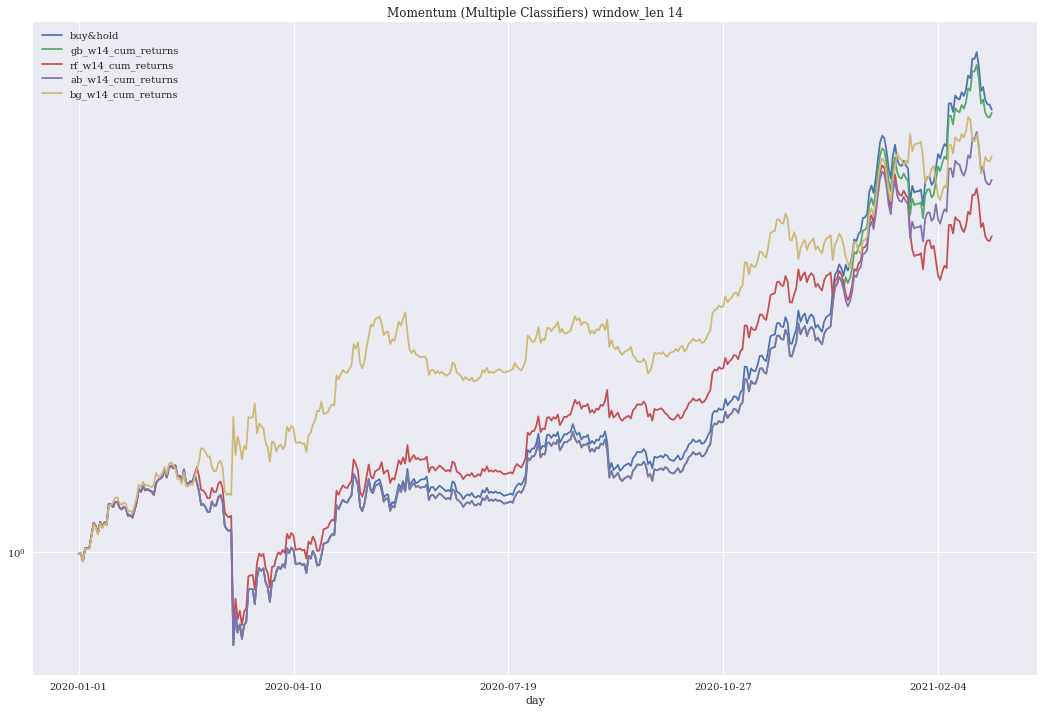

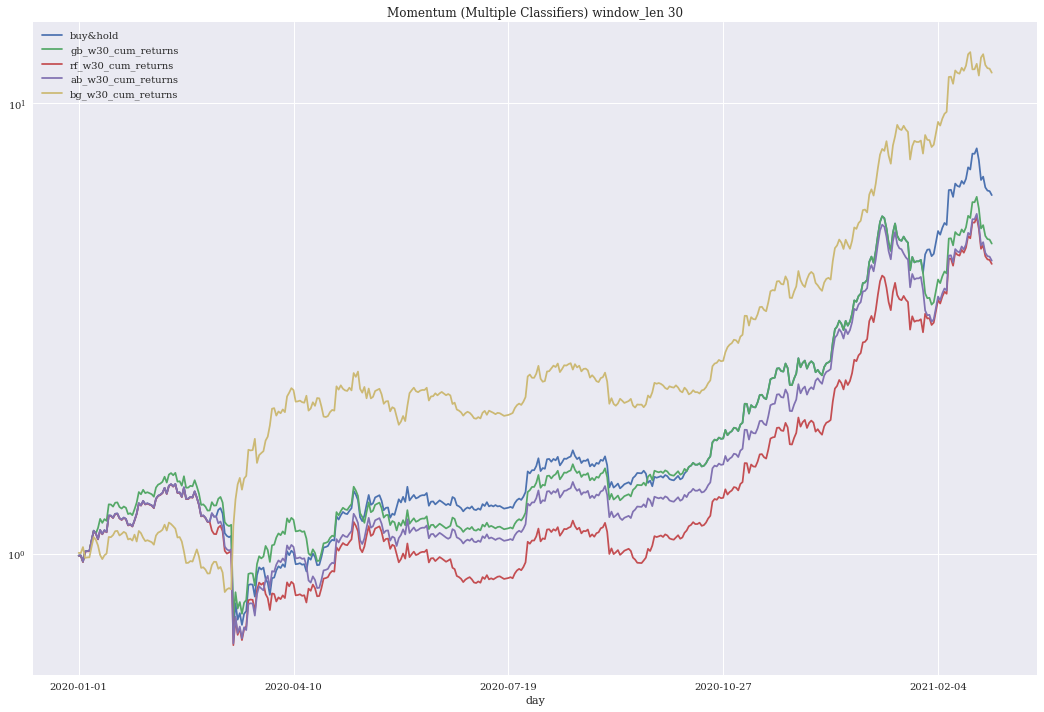

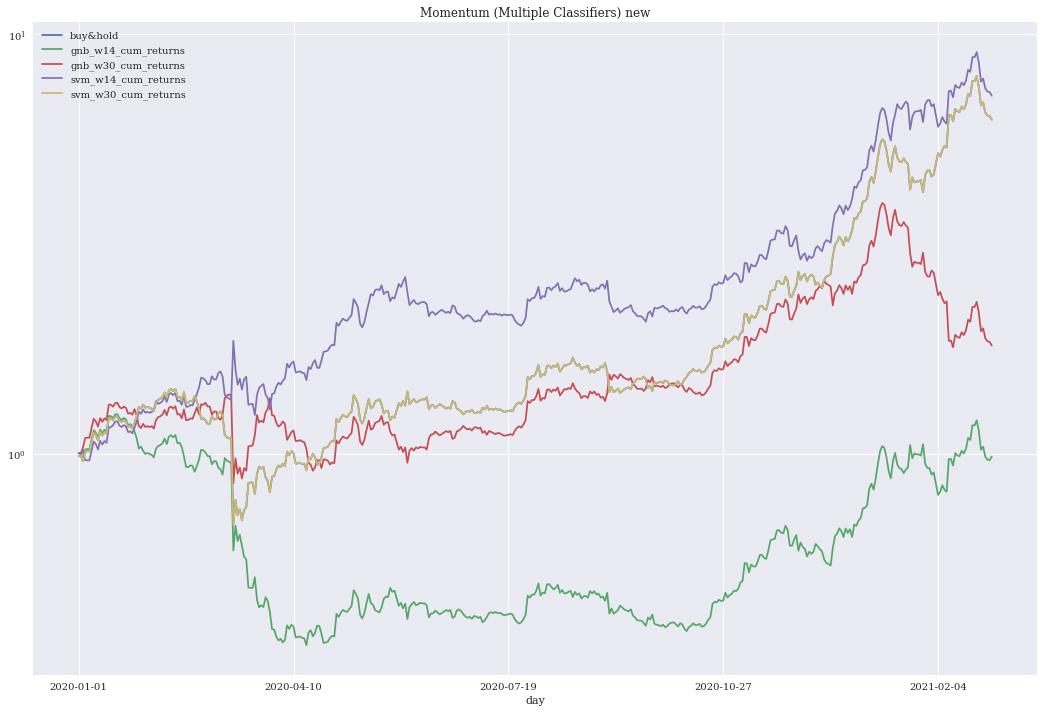

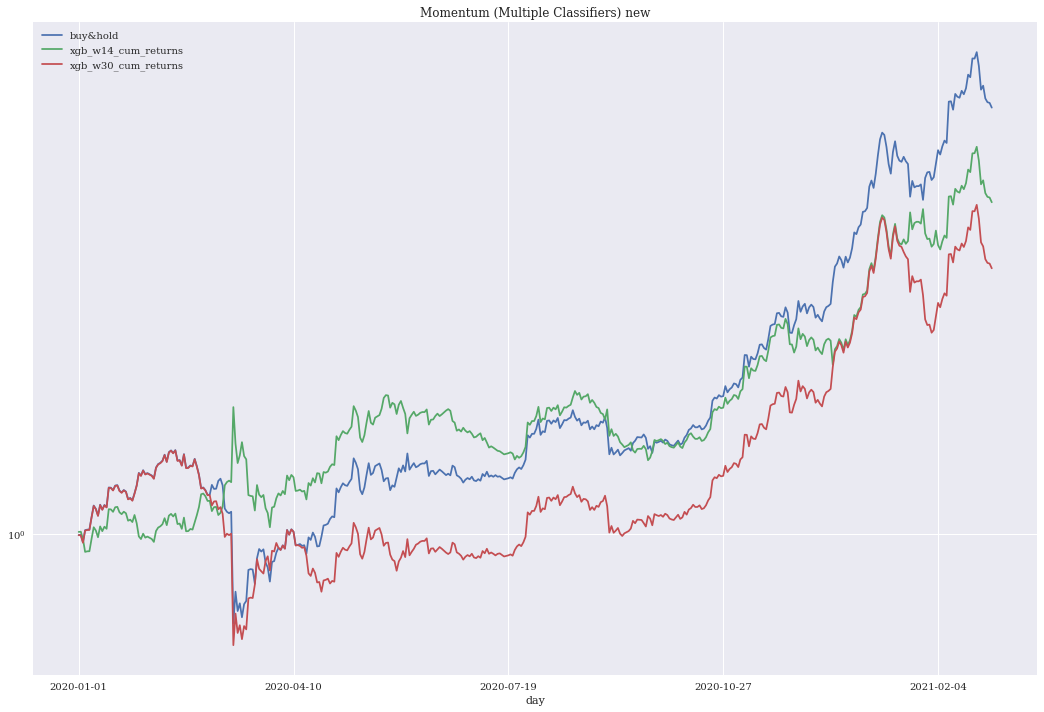

In [14]:
### returns calculation and visualization

#take proportion of the data
test_data = price[(price['day'] >= '2019-12-31')]

#find buy&hold strategy returns
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
test_data['buy&hold'] = (1+test_data['returns'].values).cumprod()
returns_data = test_data[['returns','buy&hold']].copy()


#find returns
test_data = price[(price['day'] >= '2019-12-31')]
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
for kp in preds.keys():
    test_data[kp+'_returns'] = preds[kp] * test_data['returns']
#test_data['random_strategy'] = np.where(np.random.rand(test_data.shape[0]) < 0.5, -1, 1)
#test_data['random_strategy_returns'] = test_data['random_strategy'] * test_data['returns']

#find cumulative returns
test_data = test_data[test_data['day'] >= '2020-01-01']
for kp in preds.keys():
    returns_data[kp+'_returns'] = test_data[kp+'_returns'].values
    returns_data[kp+'_cum_returns'] = (1+returns_data[kp+'_returns'].values).cumprod()
#returns_data['random_strategy_cum_returns'] = (1+test_data['random_strategy_returns'].values).cumprod()

plot_title = "Momentum (Multiple Classifiers) window_len 14"
plot_columns1 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][:4]#+['random_strategy_cum_returns']
ax = returns_data[plot_columns1].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

plot_title = "Momentum (Multiple Classifiers) window_len 30"
plot_columns1 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][4:8]#+['random_strategy_cum_returns']
ax = returns_data[plot_columns1].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

plot_title = "Momentum (Multiple Classifiers) new"
plot_columns1 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][8:12]#+['random_strategy_cum_returns']
ax = returns_data[plot_columns1].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

plot_title = "Momentum (Multiple Classifiers) new"
plot_columns1 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()][12:]#+['random_strategy_cum_returns']
ax = returns_data[plot_columns1].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

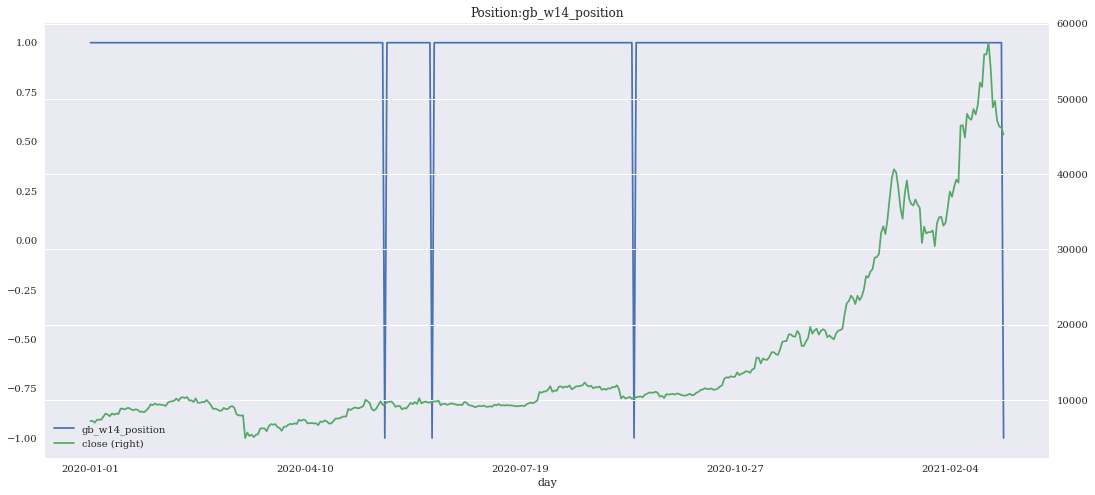

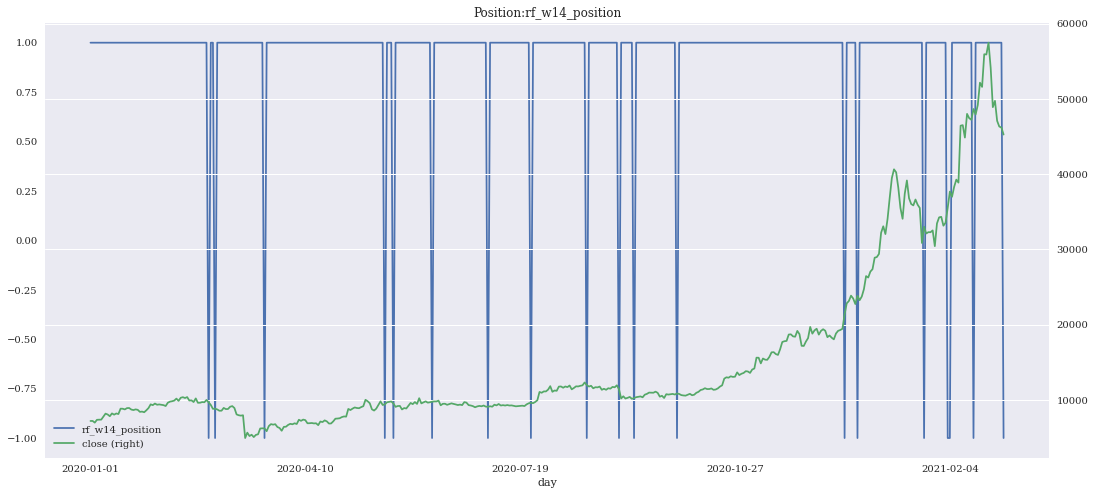

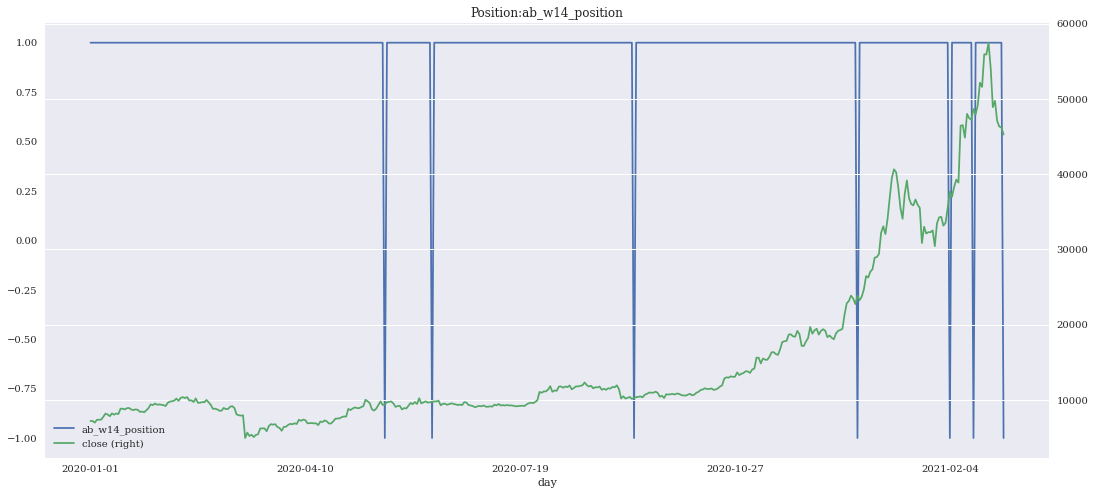

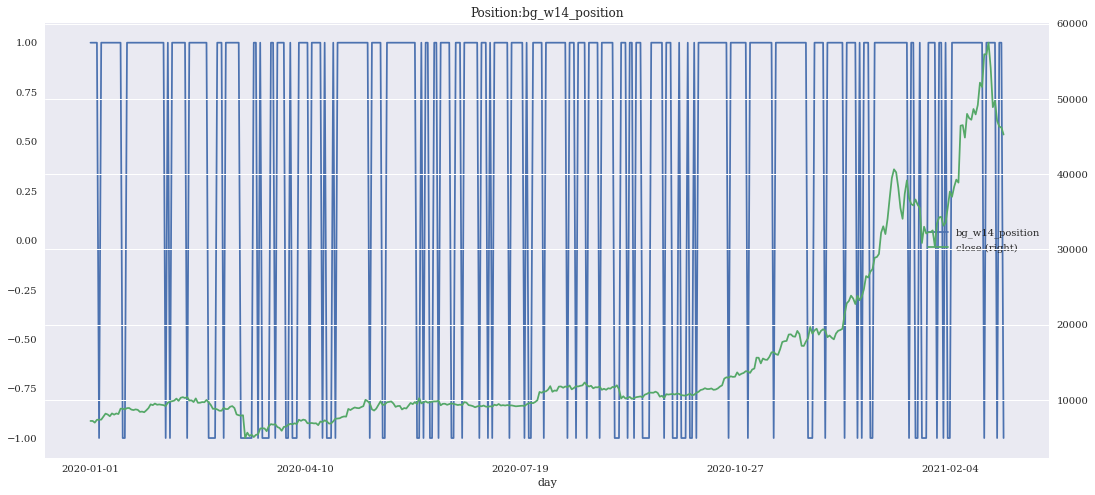

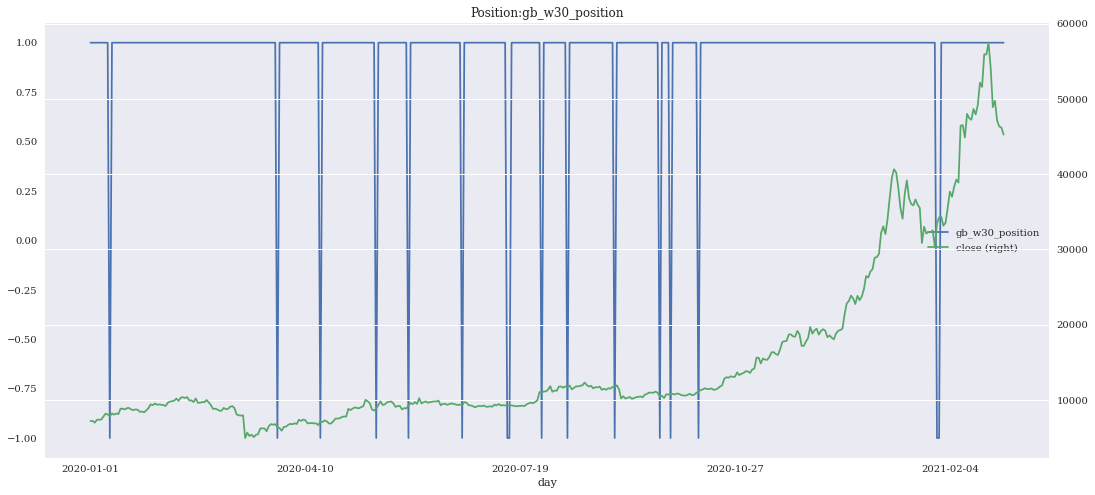

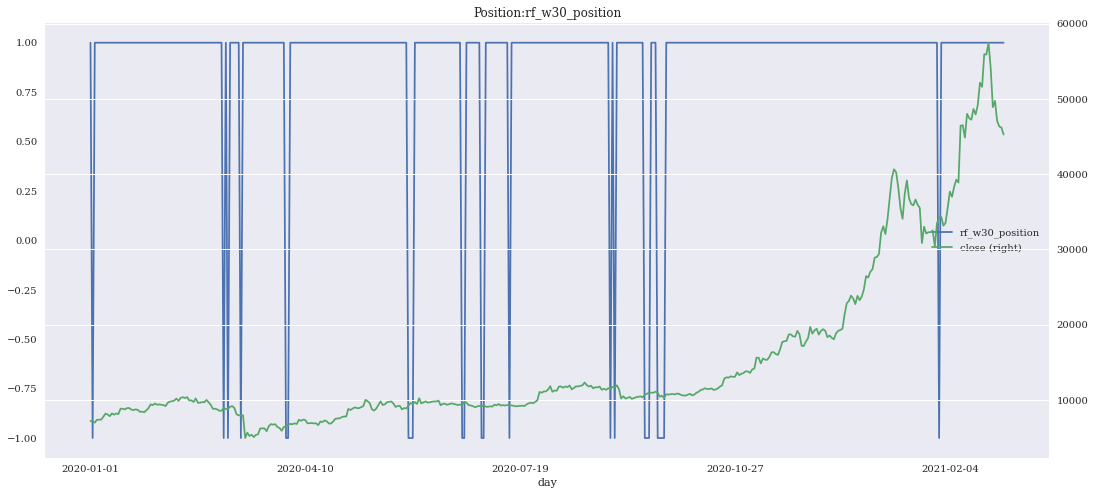

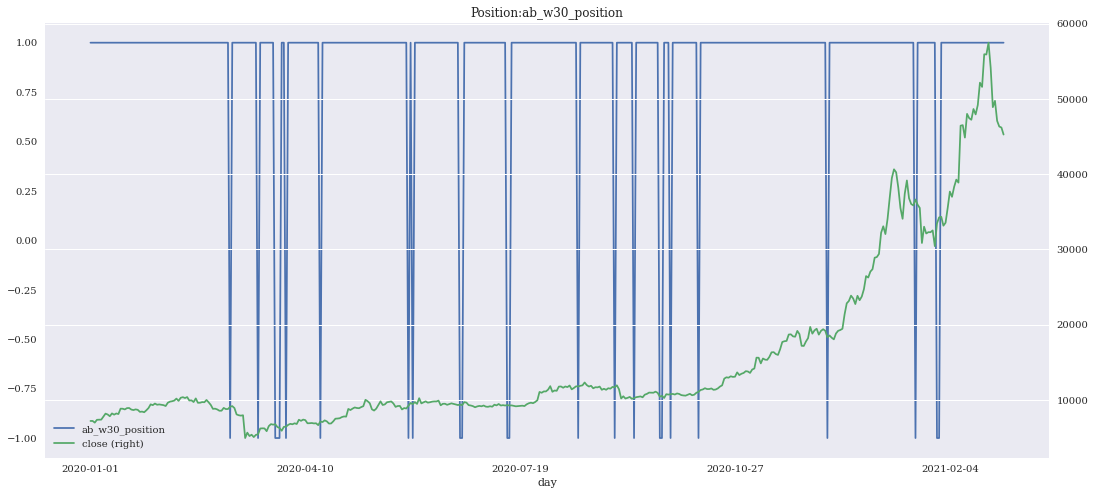

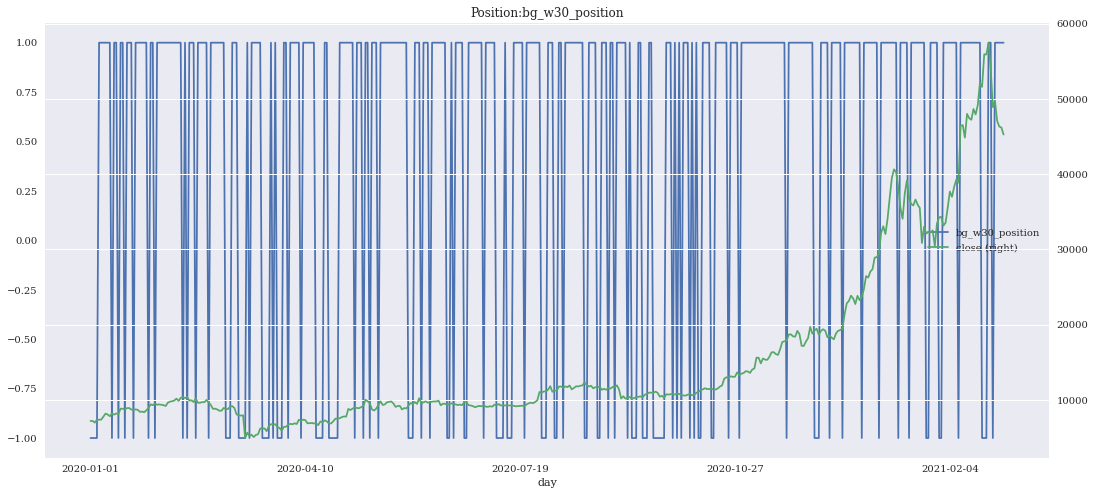

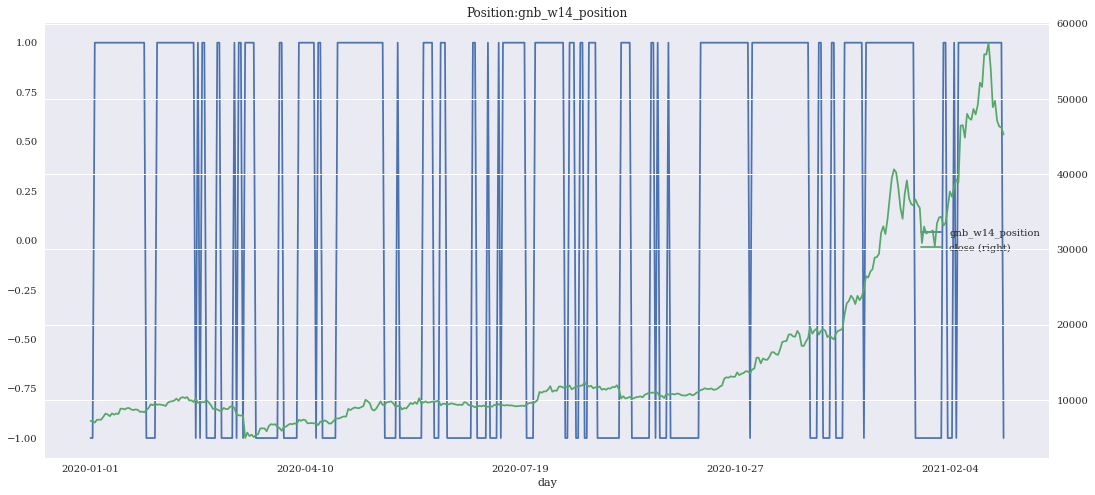

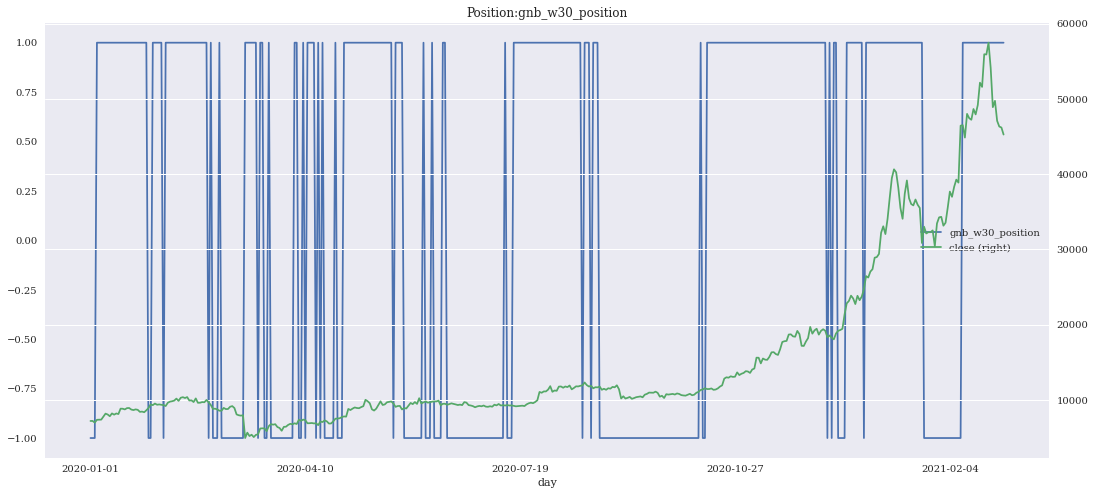

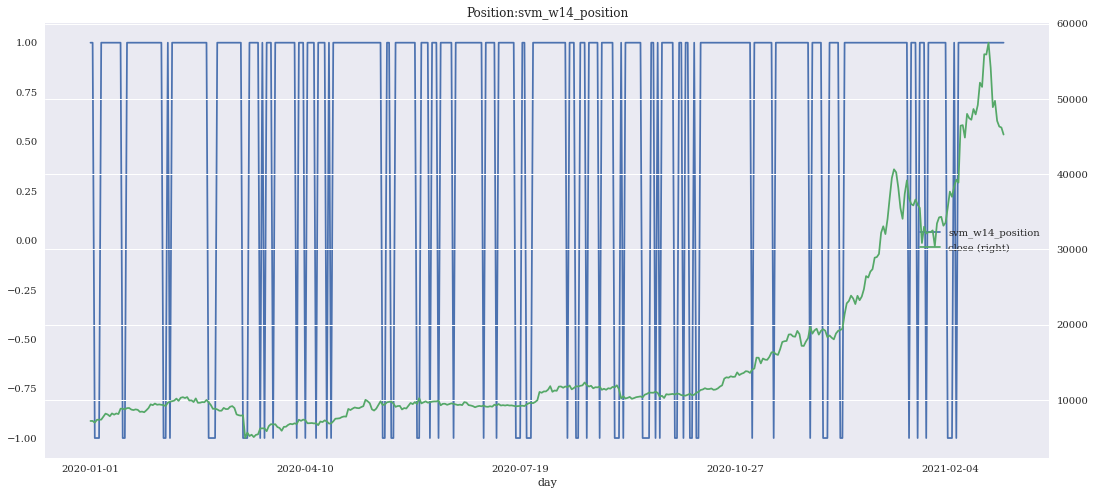

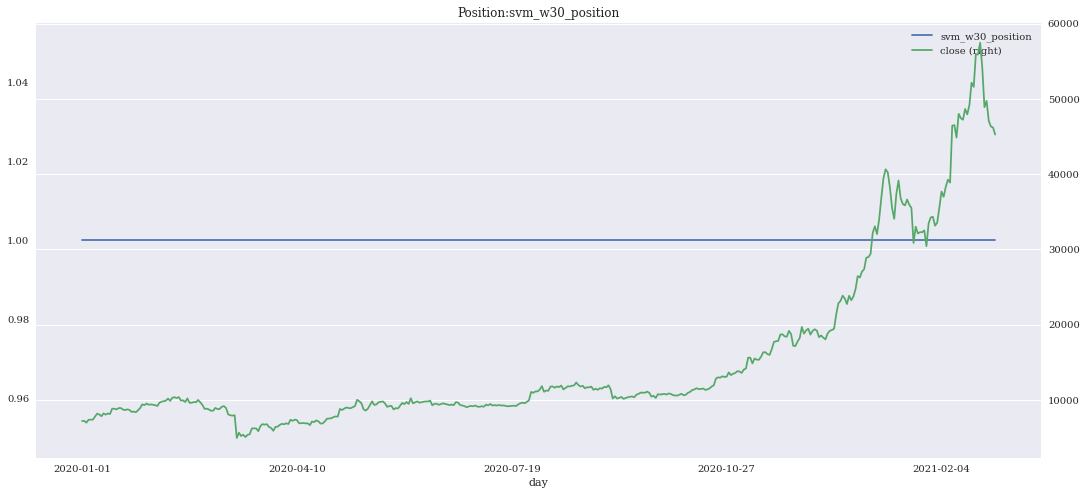

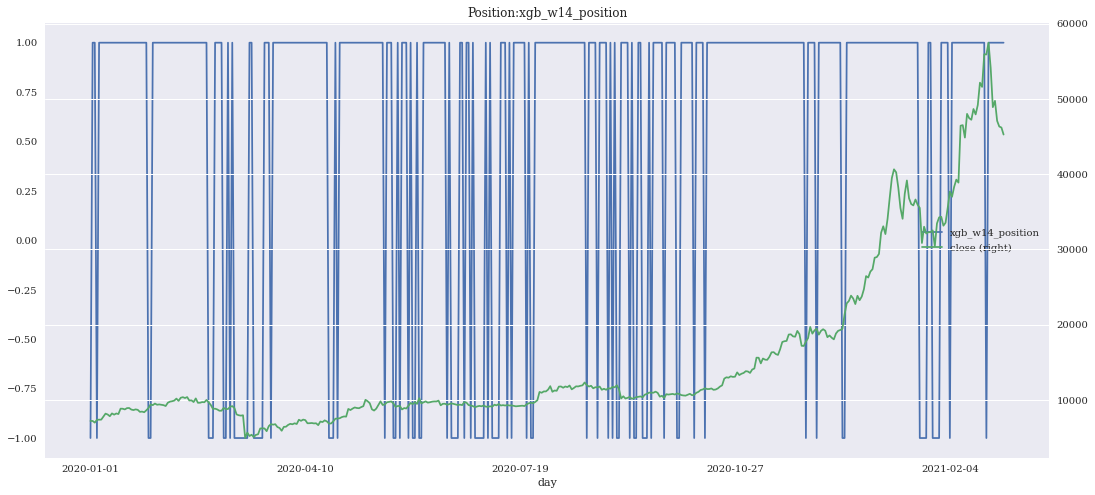

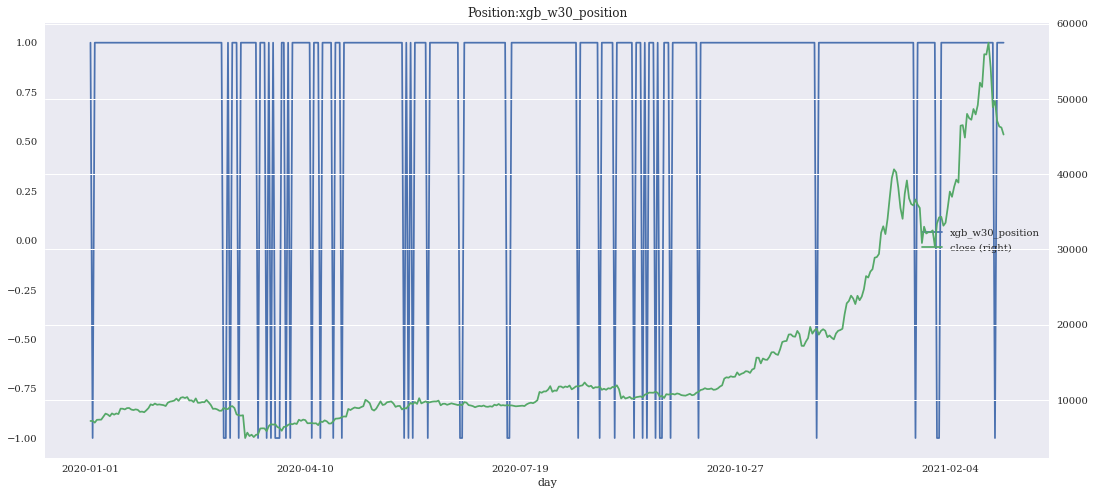

In [15]:
### Visualizing Positions
for kp in preds.keys():
    test_data[kp+'_position'] = preds[kp]
    ax = test_data[[kp+'_position','close']].plot(title='Position:'+kp+'_position',secondary_y='close',figsize=(18, 8))

In [16]:
models.keys()

dict_keys(['gb_w14', 'rf_w14', 'ab_w14', 'bg_w14', 'gb_w30', 'rf_w30', 'ab_w30', 'bg_w30', 'gnb_w14', 'gnb_w30', 'svm_w14', 'svm_w30', 'xgb_w14', 'xgb_w30'])

In [17]:
### Feature Importance Analysis

# 1st 30 -> price features
# 2nd 30 -> google trend kw:bitcoin
# 3rd 30 -> google trend kw:coinbase
# 4th 30 -> wikipedia pageview article: Bitcoin
def print_feature_ranking(model_name,window_len,feature_count=10,is_print=True):
    importances = models[model_name].feature_importances_
    indices = np.argsort(importances)[::-1]

    def decode_feature_name(i):
        if i >= 0 and i < window_len:
            return "p(t-"+str(window_len-i)+")"
        elif i >= window_len and i < window_len*2:
            return "gtb(t-"+str(window_len-i%window_len)+")"
        elif i >= window_len*2 and i < window_len*3:
            return "gtc(t-"+str(window_len-i%window_len)+")"
        elif i >= window_len*3 and i <window_len*4:
            return "wpb(t-"+str(window_len-i%window_len)+")"

    feature_names = [decode_feature_name(i) for i in indices]

    # Print the feature ranking
    if is_print:
        print("Feature ranking:")
        for f in range(window_len*4):
            print("%d. feature[%d]: %s  (%f) " % (f + 1, indices[f], feature_names[f],importances[indices[f]]))
    
    return feature_names[:feature_count],[importances[indices[i]] for i in range(feature_count)]


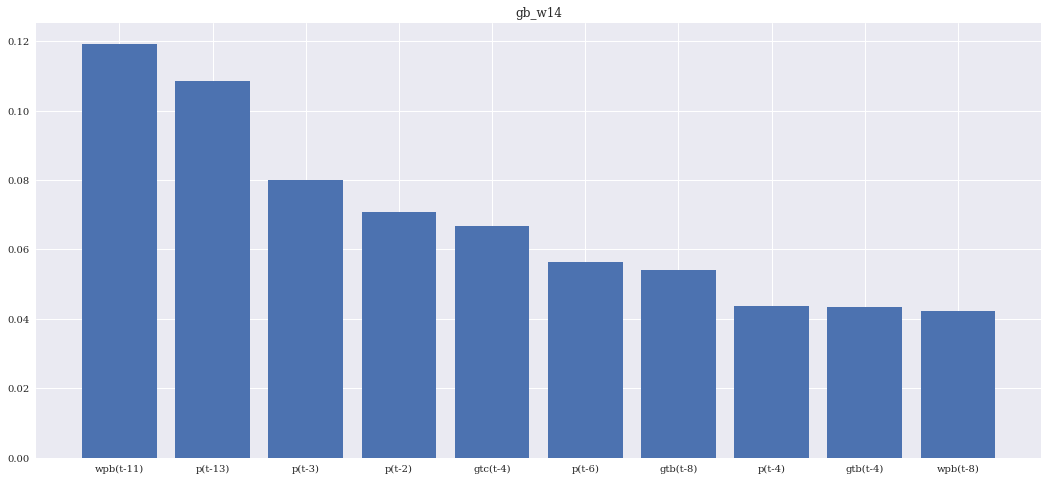

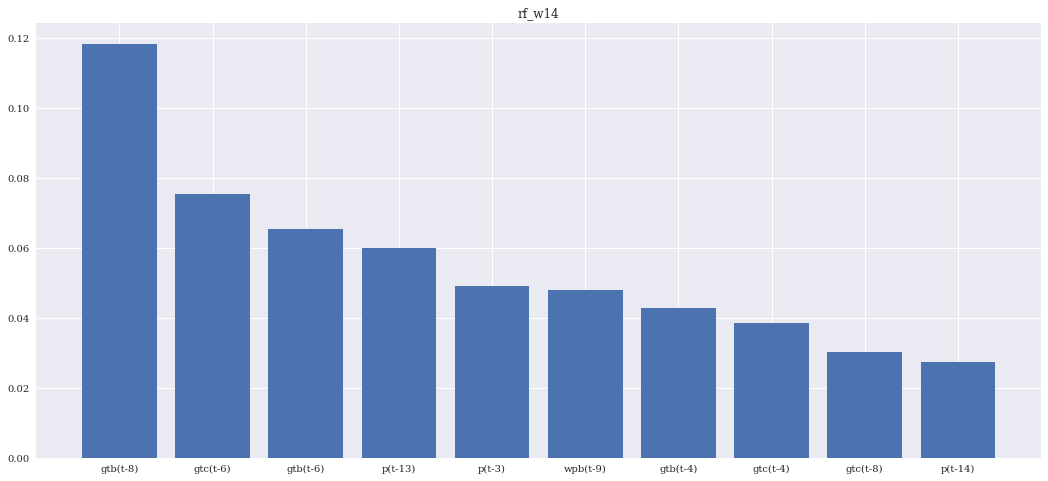

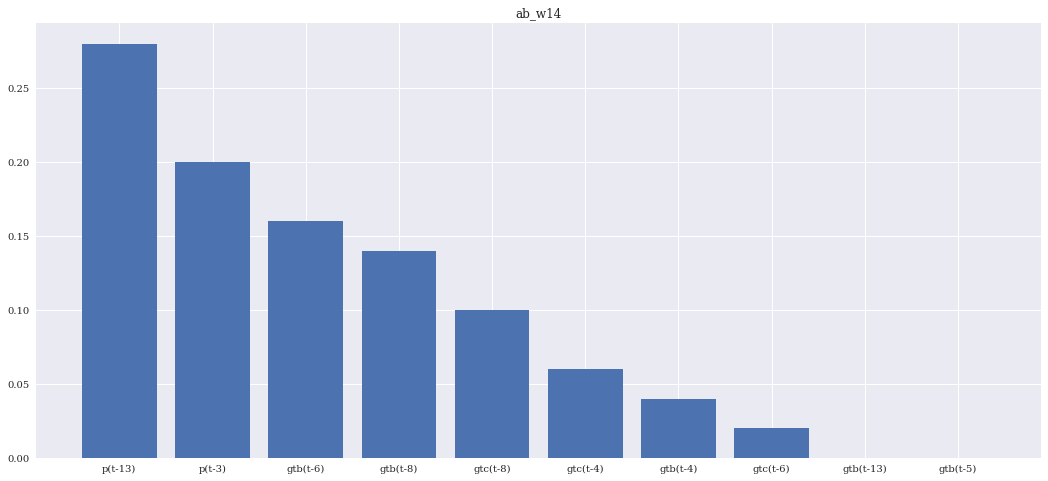

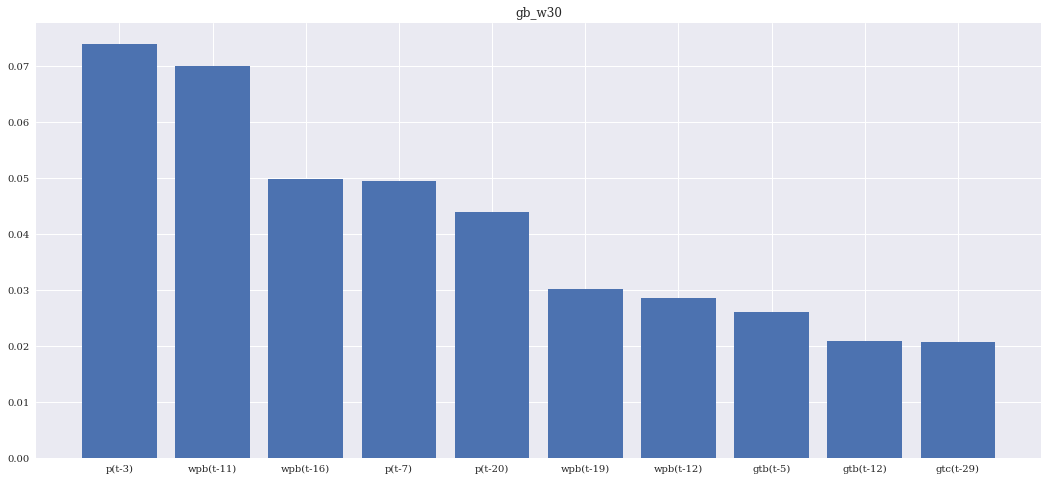

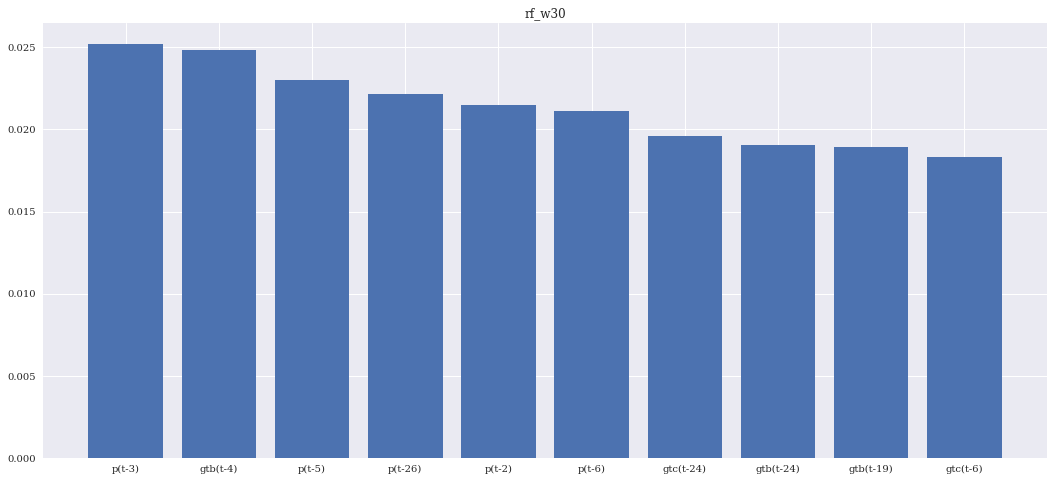

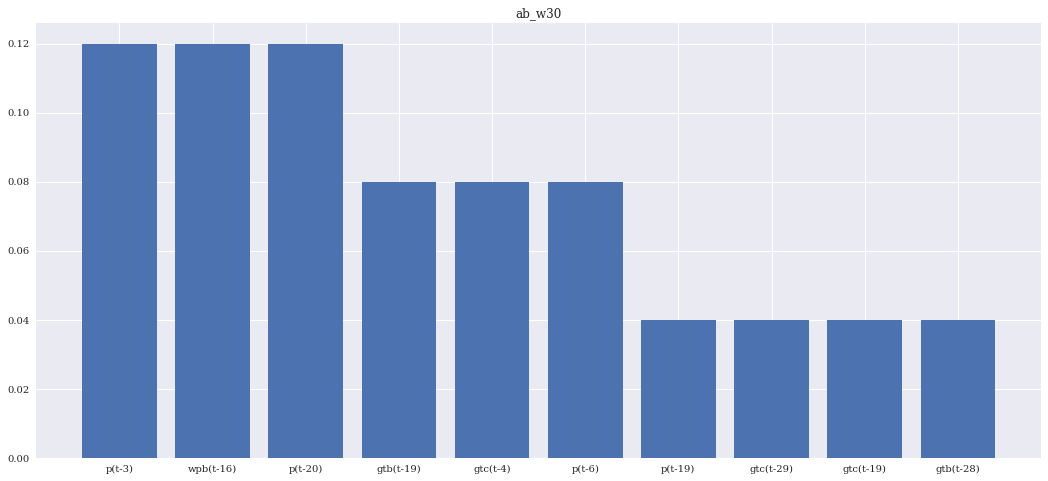

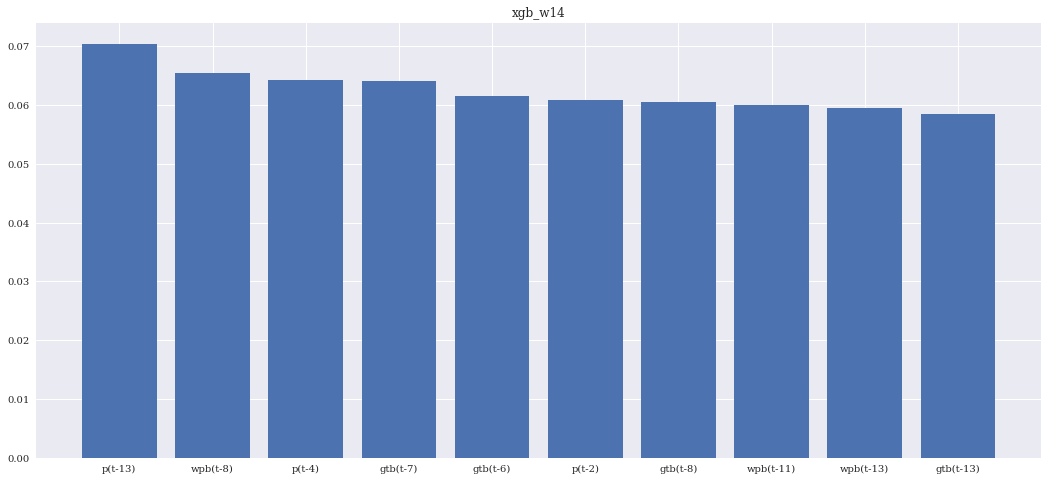

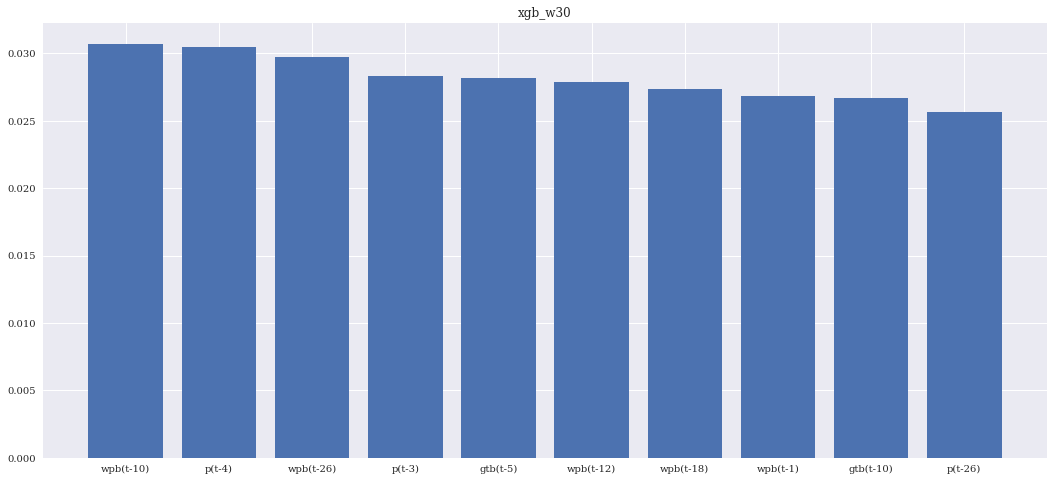

In [18]:
for k in models.keys():
    try:
        feature_names,importances = print_feature_ranking(k,int(k[-2:]),10,False)
        plt.figure(figsize=(18,8))
        plt.title(k)
        plt.bar(feature_names,importances)
    except:
        pass